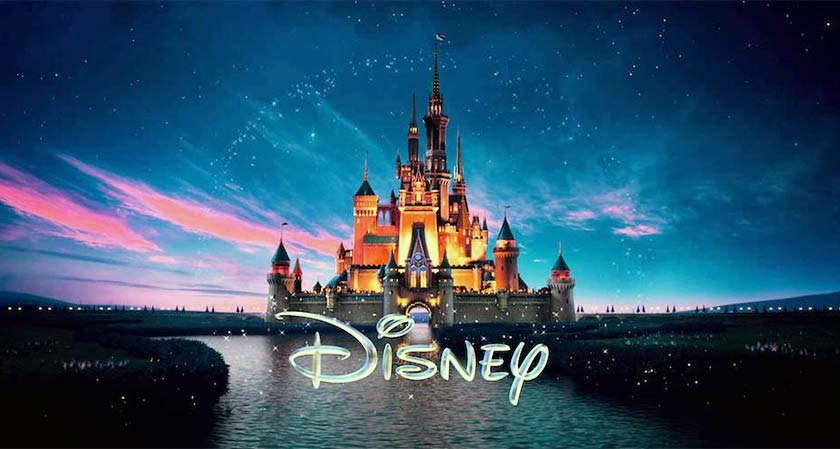
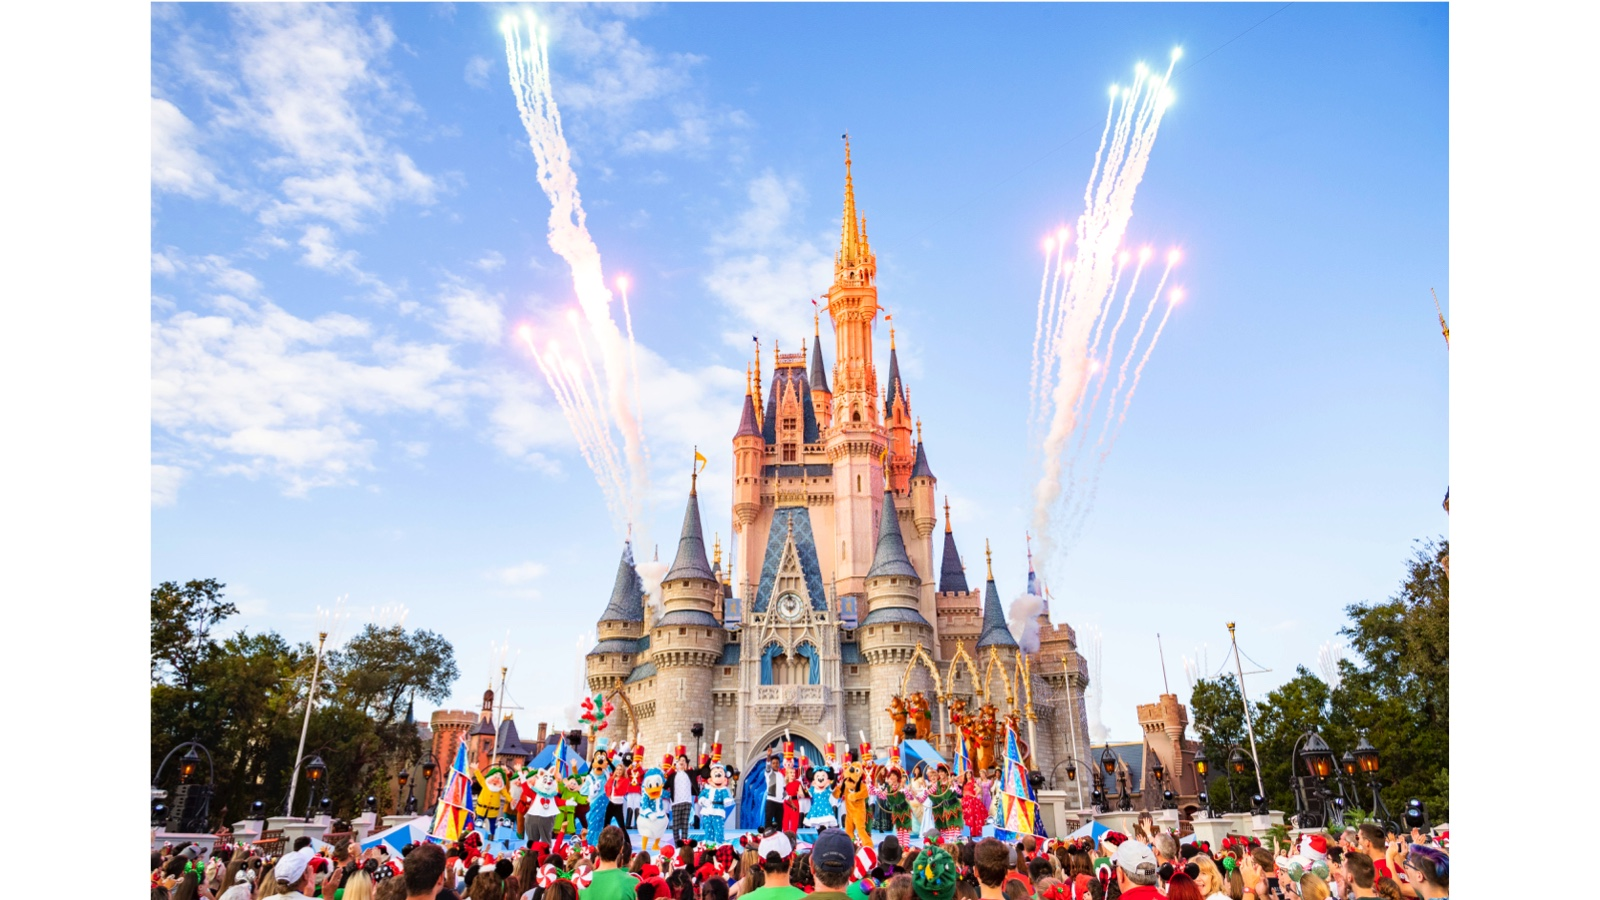

In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import torchvision
import torchvision.transforms as T
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F
import torch
from PIL import ImageFile

/kaggle/input/disney-characters-dataset/cartoon/test/pumba/51DOufyngYL.jpg
/kaggle/input/disney-characters-dataset/cartoon/test/pumba/922-9221627_timon-and-pumbaa-cartoon-character-timon-and-pumbaa.png
/kaggle/input/disney-characters-dataset/cartoon/test/pumba/37-372140_the-lion-king-clipart-grub-timon-and-pumbaa.png
/kaggle/input/disney-characters-dataset/cartoon/test/pumba/329-3293123_yogi-bear-clipart-pumbaa-not-in-front-of.png
/kaggle/input/disney-characters-dataset/cartoon/test/pumba/143-1431696_the-lion-king-clipart-grub-timon-and-pumbaa.png
/kaggle/input/disney-characters-dataset/cartoon/test/pumba/225-2250638_timon-and-pumbaa-dancing-cartoon-timon-and-pumbaa.png
/kaggle/input/disney-characters-dataset/cartoon/test/pumba/341-3413268_lion-king-pumbaa-clipart-hd-png-download.png
/kaggle/input/disney-characters-dataset/cartoon/test/pumba/807-8073301_timon-and-pumbaa-cartoon-character-timon-and-pumbaa.png
/kaggle/input/disney-characters-dataset/cartoon/test/pumba/41-411600_timon-y-p

In [66]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# **Loading Data Train and Resize it**

In [67]:
dataroot ='../input/disney-characters-dataset/cartoon/train/'
trainloader = datasets.ImageFolder(dataroot, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

trainloader = DataLoader(trainloader, batch_size, shuffle=True, num_workers=3, pin_memory=True)

# **Loading Data Test and Resize it**

In [68]:
dataroot='../input/disney-characters-dataset/cartoon/test/'
testloader = datasets.ImageFolder(dataroot, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

testloader = DataLoader(testloader, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [69]:
classes = ('donald', 'mickey', 'minion', 'olaf',
            'pooh', 'pumba')

In [70]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

****if there is any image incomplete PIL Library will complete it when u set it's value true.****

# **Data Preprocessing** #

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


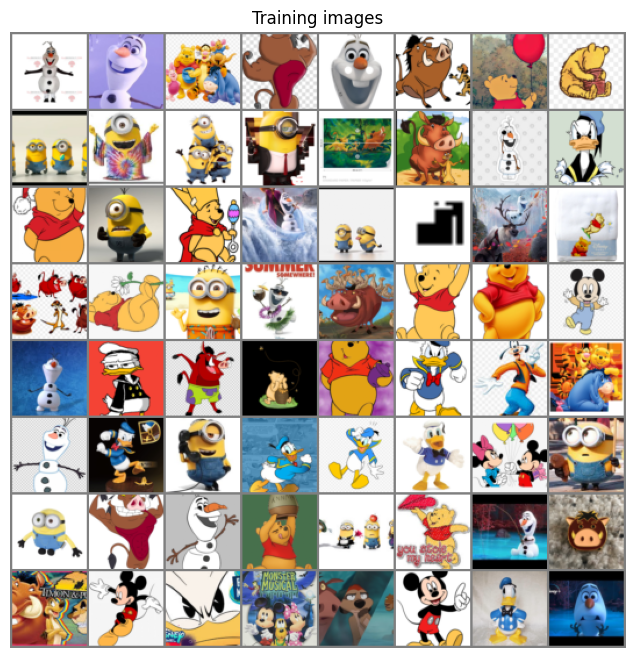

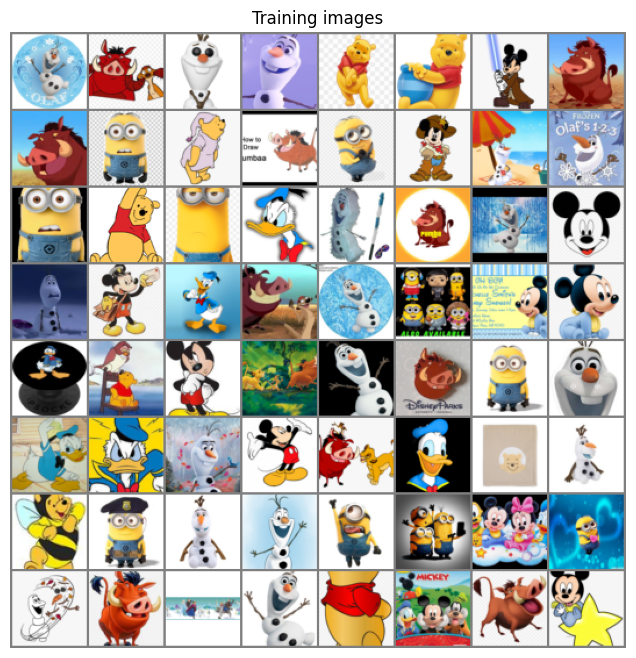

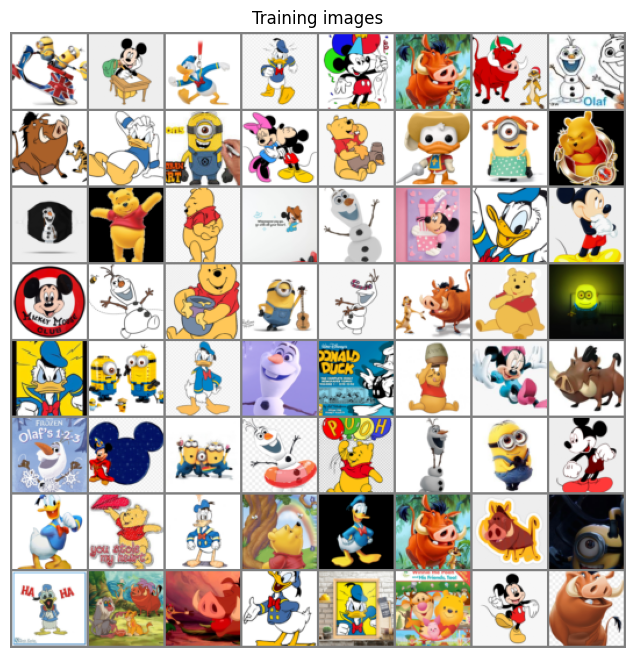

In [71]:
def imshow(img,title):
    # scales the pixel values in img to rescale them from [-1, 1]
    # to [0, 1] for proper visualization.
    
    img = img / 2 + 0.5  
    
    # Converts the PyTorch tensor img to a NumPy array for compatibility with Matplotlib.
    npimg = img.numpy()
    
    plt.figure(figsize=(8,8))
    
    plt.title(title)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    # Removes the axis labels and ticks for the displayed image.
    plt.axis('off')
    
    plt.show()

dataiter = iter(trainloader)
# Specify the number of figures you want to display (e.g., 3)
num_figures_to_display = 3

for images, labels in trainloader:
    # Show images
    imshow(torchvision.utils.make_grid(images), "Training images")
    num_figures_to_display -= 1
    if num_figures_to_display == 0:
        break


In [72]:
# converts the trainloader, which is a PyTorch DataLoader, 
# into an iterator using the iter() function. This allows you to easily get batches of data.
dataiter = iter(trainloader)

for images, labels in trainloader:
    print('The Shape of Images = ' , images.shape)
    print('The Labels shape = ' , labels.shape)
    break  # Only print the shape of the first batch

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The Shape of Images =  torch.Size([64, 3, 64, 64])
The Labels shape =  torch.Size([64])


# **Model Training**

In [73]:
# Net Class inherits from Module Class (Base Class for all pytorch modules)
class Net(nn.Module):  
    # The constructor (__init__) of the Net class defines the architecture of the neural network. 
    # It consists of two main parts:
    def __init__(self):
        super(Net, self).__init__()
        
        # 1- The Convolutional Layers:
        self.cnn_layers = nn.Sequential(
          # Covolutional Operation.
          # 3 channels and outputs 4 feature maps
          nn.Conv2d(3,4, kernel_size=3, stride=1, padding=1),
        
         # Batch Normalization --> is applied to normalize the output of each convolutional layer, which helps with training stability.
          nn.BatchNorm2d(4),
            
          # the Activate Function of our NN Model is RelU.
          nn.ReLU(inplace=True),
            
          # Max Pooling --> with 2 * 2 kernal size, reduces the spatial dimensions of the feature maps.
          nn.MaxPool2d(kernel_size=2, stride=2),
            
            
          # Second Convolutional Layer.
          nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
      )

        # 2- The Linear Layers --> defines the fully connected (linear) layers of the neural network:
        # this Linear layer classifies int 6 classes.
        self.linear_layers = nn.Sequential(nn.Linear(4* 16 * 16, 6)) 
    
    # Forward Pass of the model.   
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# **Preparing The model for the Neural Network Training**

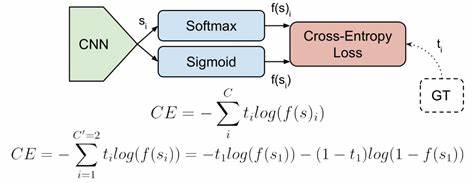

In [74]:
model = Net()

# use Adam Optimizer to update the parameters during Training.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss Function
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
# prints a summary of the model, showing its architecture and layers.
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1024, out_features=6, bias=True)
  )
)


In [75]:
if torch.cuda.is_available():
    torch.device('cuda')
else:
    torch.device('cpu')

In [76]:
# Check the loss at each epoch.
for i in range(10):
    running_loss = 0
    for images, labels in trainloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()  
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1 - Training loss: 1.4688475376793317


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 2 - Training loss: 0.8856239553008761


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3 - Training loss: 0.8075552210211754


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 4 - Training loss: 0.6957895388560635


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5 - Training loss: 0.6493317240050861


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 6 - Training loss: 0.5978524456066745


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 7 - Training loss: 0.6076183170080185


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 8 - Training loss: 0.4870679756360395


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 9 - Training loss: 0.5153857746294567


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 10 - Training loss: 0.46649036716137615


# **Calculate the Model's Accuracy and Number of Tested Images**

In [77]:
correct_count, all_count = 0, 0
for images, labels in testloader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
    
        with torch.no_grad():  
            output = model(images)
        ps = torch.exp(output)
        probab = list(ps.cpu()[i])  
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 433

Model Accuracy = 0.8267898383371824


# **Test The Model using Test Dataset**

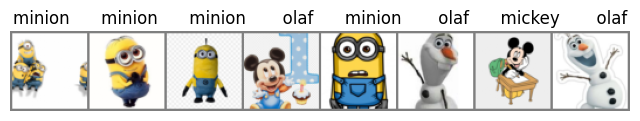

In [82]:
_, predicted = torch.max(output, 1)
imshow(torchvision.utils.make_grid(images[:8]).cpu().clone(), '      '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))